# Noisy Rosenbrock Optimization

Consider optimizing a noisy variant of the Rosenbrock function. The standard Rosenbrock function is defined as:

$$
f_{\text{rosenbrock}}(\mathbf{x}) = \sum_{i=1}^{D-1} \left[ 100 (\mathbf{x}_i^2 - \mathbf{x}_{i+1})^2 + (\mathbf{x}_i - 1)^2 \right],
$$

which achieves its global minimum $f_{\text{rosenbrock}}(\mathbf{x}^*) = 0$ at $\mathbf{x}^* = (1,1,\ldots,1)^T$. This function decomposes naturally into $D-1$ element functions:

$$
f_{\text{rosenbrock}}(\mathbf{x}) = \sum_{i=1}^{D-1} f_i(\mathbf{x}),
$$

where each $f_i(\mathbf{x}) = 100 (\mathbf{x}_i^2 - \mathbf{x}_{i+1})^2 + (\mathbf{x}_i - 1)^2$ depends exclusively on the $i$-th and $(i+1)$-th components of $\mathbf{x}$.

We introduce multiplicative noise to this function, creating the modified objective:

$$
\widetilde{f}(\mathbf{x}) = \sum_{i=1}^{D-1} \left[ f_i(\mathbf{x}) \cdot (1 + \varepsilon \cdot \xi_i) \right],
$$

where $\varepsilon > 0$ is a small noise coefficient, and each $\xi_i$ is an independent random variable with $\mathbb{E}[\xi_i] = 0$ and $\text{Var}(\xi_i) = 1$.

The problem definition begins with the following code:

In [1]:
import matplotlib.pyplot as plt
from upoqa.problems import PSProblem
import numpy as np

# Define the element function
def rosenbrock_ele(z):    # input is z = [x[i-1], x[i]] for each i-th element
    return 100.0 * (z[0] ** 2 - z[1]) ** 2 + (z[0] - 1) ** 2

# there are 19 elements
D = 20

# every element is the same as rosenbrock_ele
elements = dict([(f"ele {i}", rosenbrock_ele) for i in range(1, D)])

# the i-th element depends on x[i-1] and x[i] 
coords = dict([(f"ele {i}", [i - 1, i]) for i in range(1, D)])

# Tne elemental noise
eps = 5e-3
def noise(f: float, *args):
    return f * (1 + eps * np.random.randn())

# create the problem
prob = PSProblem(elements, coords, noise_wrapper = noise)
prob.update_meta_info({'name': 'Rosenbrock'})
print(prob)

# let's start from [-1, -1, ..., -1]
x0 = - np.ones(prob.dim)

The Rosenbrock Problem with 19 Elements and 20 Dimensions.


First, let's optimize the problem using conventional methods, and none of these methods converge near the solution.

Function value obtained by COBYQA: 18.77492619915688
Function value obtained by COBYLA: 18.87100851395784
Function value obtained by UPOQA: 17.825729297079132


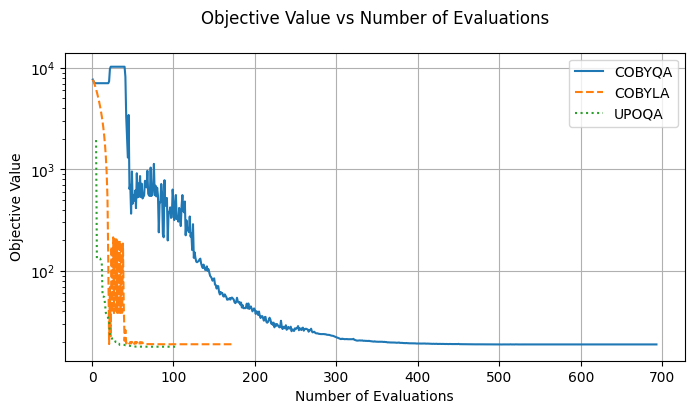

<Figure size 640x480 with 0 Axes>

In [2]:
import scipy
import upoqa
from itertools import cycle

prob.set_figure_size((8, 4))

PLOT_LINE_FMT_CYCLER = iter(cycle(['-', '--', ':', '-.']))
PLOT_MARKER_FMT_CYCLER = iter(cycle(['o', 's', '^', 'D', '+', '*']))

# COBYQA
res_cobyqa = scipy.optimize.minimize(prob.fun_eval, x0, method='cobyqa')
print("Function value obtained by COBYQA:", res_cobyqa.fun)
prob.disp_fun_history(label = "COBYQA", show_fig = False, fmt = next(PLOT_LINE_FMT_CYCLER))
prob.clear()

# COBYLA
res_cobyla = scipy.optimize.minimize(prob.fun_eval, x0, method='cobyla')
print("Function value obtained by COBYLA:", res_cobyla.fun)
prob.disp_fun_history(label = "COBYLA", show_fig = False, fmt = next(PLOT_LINE_FMT_CYCLER))
prob.clear()

# UPOQA
def nfev_recorder(intermediate_result):
    with prob.debug_mode(incre_nfev = False, noisy = False):
        fval_nf = prob.fun_eval(intermediate_result.x)
    prob._update_history_fun(fval_nf)
    
res_upoqa = upoqa.minimize(prob.fun, x0, coords, callback = nfev_recorder, disp = False)
print("Function value obtained by UPOQA:", res_upoqa.fun)
prob.disp_fun_history(label = "UPOQA", show_fig = True, fmt = next(PLOT_LINE_FMT_CYCLER))
prob.clear()

None of these methods appear to converge to the optimal solution (function value = 0.0). We now configure `upoqa` with `noise_level = 1`, which activates two key features:

1. **Expanded interpolation points**: The algorithm slightly increases the number of interpolation points used for function modeling, enhancing modeling accuracy in noisy environments.
2. **Restart mechanism**: Similar to the approach used in `pybobyqa`, this feature enables the algorithm to restart with an enlarged trust-region radius upon convergence detection, increasing the probability of discovering improved solutions.

Function value obtained by UPOQA with noise_level = 1: 1.4043661133316282e-11
Solution obtained by UPOQA with noise_level = 1: [1.         1.00000001 0.99999999 0.99999999 1.00000003 1.00000003
 1.00000009 1.00000013 1.00000005 1.00000001 1.         1.
 1.00000003 0.99999997 0.99999995 0.9999999  0.99999981 0.99999965
 0.99999942 0.99999861]


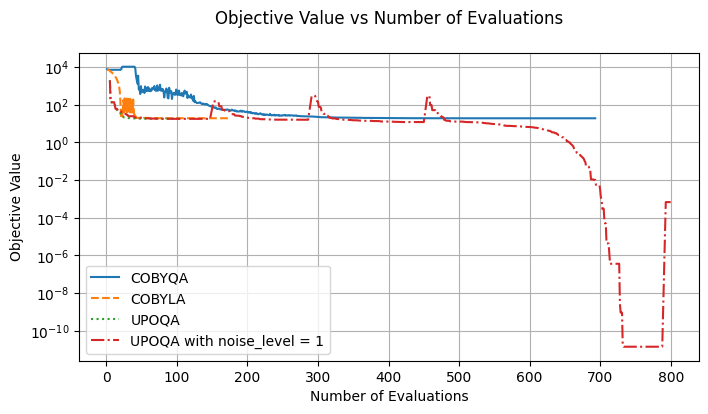

<Figure size 640x480 with 0 Axes>

In [3]:
res_upoqa_n1 = upoqa.minimize(prob.fun, x0, coords, disp = False, 
                              noise_level = 1, maxfev = 800, callback = nfev_recorder)
print("Function value obtained by UPOQA with noise_level = 1:", res_upoqa_n1.fun)
print("Solution obtained by UPOQA with noise_level = 1:", res_upoqa_n1.x)
prob.disp_fun_history(label = "UPOQA with noise_level = 1", show_fig = True, fmt = next(PLOT_LINE_FMT_CYCLER))
prob.clear()